# Intro

- This uses lazy polars less than normal, just so we can show you intermediate results. Lazy mode should be your default

In [1]:
from pathlib import Path
import json
import glob
from datetime import datetime, time, date
import math

import requests
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import pyarrow.compute as pc


sns.set_style("ticks")
pd.options.display.max_rows = 5

data_dir = Path("data")
extracted = (
    data_dir / "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_1.csv"
)


In [4]:
fec_dir = Path("data/fec")


In [5]:
dtypes = {
    "CMTE_ID": pl.Utf8,
    "EMPLOYER": pl.Categorical,
    "OCCUPATION": pl.Categorical,
    "TRANSACTION_DT": pl.Utf8,
    "TRANSACTION_AMT": pl.Int32,
}
with zipfile.ZipFile(dest) as z:
    x=pl.read_csv(
        z.read("itcont.txt"),
        has_header=False,
        columns=[0, 11, 12, 13, 14],
        new_columns=list(dtypes.keys()),
        sep="|",
        dtypes=dtypes,
        encoding="cp1252",
    )

In [31]:
import polars as pl
df = pl.DataFrame([
    pl.Series("a", ["bob", "bill", "alice", "mike", "bill", "bill", None], pl.Categorical),
    pl.Series("b", ["foo", "bar", "boo", "bob", "clams", None, None], pl.Categorical),
])
df.write_parquet("tmp.pq")
with pl.StringCache():
    print(pl.scan_parquet("./*tmp.pq").select(pl.col("a").value_counts()).collect(streaming=True))

shape: (5, 1)
┌─────────────┐
│ a           │
│ ---         │
│ struct[2]   │
╞═════════════╡
│ {"bob",1}   │
│ {null,1}    │
│ {"alice",1} │
│ {"mike",1}  │
│ {"bill",3}  │
└─────────────┘


In [4]:
import asyncio
from zipfile import ZipFile
from pathlib import Path
from io import BytesIO
import httpx

fec_dir = Path("data/fec")

async def download_and_save_cm(year: str, client: httpx.AsyncClient):
    cm_cols = ["CMTE_ID", "CMTE_NM", "CMTE_PTY_AFFILIATION"]
    dtypes = {"CMTE_PTY_AFFILIATION": pl.Categorical}
    url = f"https://www.fec.gov/files/bulk-downloads/20{year}/cm{year}.zip"
    resp = await client.get(url)
    with ZipFile(BytesIO(resp.content)) as z:
        pl.read_csv(
            z.read("cm.txt"),
            has_header=False,
            columns=[0, 1, 10],
            new_columns=cm_cols,
            sep="|",
            dtypes=dtypes,
        ).write_parquet(fec_dir / f"cm{year}.pq")

async def download_and_save_indiv(year: str, client: httpx.AsyncClient):
    dtypes = {
        "CMTE_ID": pl.Utf8,
        "EMPLOYER": pl.Categorical,
        "OCCUPATION": pl.Categorical,
        "TRANSACTION_DT": pl.Utf8,
        "TRANSACTION_AMT": pl.Int32,
    }
    url = f"https://www.fec.gov/files/bulk-downloads/20{year}/indiv{year}.zip"
    resp = await client.get(url)
    with ZipFile(BytesIO(resp.content)) as z:
        pl.read_csv(
            z.read("itcont.txt"),
            has_header=False,
            columns=[0, 11, 12, 13, 14],
            new_columns=list(dtypes.keys()),
            sep="|",
            dtypes=dtypes,
            encoding="cp1252",
        ).with_column(
            pl.col("TRANSACTION_DT").str.strptime(pl.Date, fmt="%m%d%Y", strict=False)
        ).write_parquet(
            fec_dir / f"indiv{year}.pq"
        )

years = ["08", "10", "12", "14", "16"]
if not fec_dir.exists():
    fec_dir.mkdir()
    async with httpx.AsyncClient(follow_redirects=True, timeout=None) as client:
        cm_tasks = [download_and_save_cm(year, client) for year in years]
        indiv_tasks = [download_and_save_indiv(year, client) for year in years]
        tasks = cm_tasks + indiv_tasks
        await asyncio.gather(*tasks)

In [2]:
import dask.dataframe as dd
from dask import compute

In [27]:
%%time
files = sorted(fec_dir.glob("indiv*.pq"))

total_counts_pd = pd.Series(dtype="int64")

for year in files:
    occ_pd = pd.read_parquet(year, columns=["OCCUPATION"], engine="pyarrow")
    counts = occ_pd["OCCUPATION"].value_counts()
    total_counts_pd = total_counts_pd.add(counts, fill_value=0).astype("int64")

total_counts_pd.nlargest(100).head()

CPU times: user 8.68 s, sys: 560 ms, total: 9.24 s
Wall time: 9.11 s


RETIRED         4773715
NOT EMPLOYED    2715939
ATTORNEY        1339919
PHYSICIAN        660786
HOMEMAKER        494619
dtype: int64

In [44]:
occ_dd = dd.read_parquet(
    fec_dir / "indiv*.pq", engine="pyarrow", columns=["OCCUPATION"]
)
n_rows = 10000
most_common_dd = occ_dd["OCCUPATION"].head(n_rows).value_counts()
most_common_dd.head()


RETIRED      1084
ATTORNEY      904
PRESIDENT     655
EXECUTIVE     467
HOMEMAKER     434
Name: OCCUPATION, dtype: int64

In [45]:
with pl.StringCache():  # otherwise we can't read categoricals from multiple files
    occ_pl = pl.scan_parquet(fec_dir / "indiv*.pq", cache=False)
    counts = (
        occ_pl
        .select(pl.col("OCCUPATION").head(n_rows).value_counts(multithreaded=True, sort=True))
        .collect()
    )
counts.head()

OCCUPATION
struct[2]
"{""ACCOUNTANT"",1084}"
"{""MANUFACTURER & DEVELOPER"",904}"
"{""ATTORNEY, RETIRED"",655}"
"{""ATTORNEY"",467}"
"{""PRESIDENT & CEO"",434}"


In [39]:
with pl.StringCache():  # otherwise we can't read categoricals from multiple files
    occ_pl = pl.scan_parquet(fec_dir / "indiv*.pq", cache=False)
    x = (
        occ_pl
        .select(pl.col("OCCUPATION").head(n_rows))
        .collect()
    )
x

OCCUPATION
cat
"""PUBLIC RELATIO..."
"""PUBLIC RELATIO..."
"""PUBLIC RELATIO..."
null
null
null
null
null
null


In [42]:
import polars as pl
df1 = pl.DataFrame([
    pl.Series("a", ["foo", "bar", "foo"], pl.Categorical)
])
df2 = pl.DataFrame([
    pl.Series("a", ["foo", "baz", "foo"], pl.Categorical)
])
df1.write_parquet("tmp/df1.pq")
df2.write_parquet("tmp/df2.pq")
with pl.StringCache():
    print(pl.read_parquet("tmp/*.pq").select(pl.col("a").value_counts(multithreaded=True, sort=True)))

shape: (3, 1)
┌───────────┐
│ a         │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {"foo",4} │
│ {"baz",1} │
│ {"bar",1} │
└───────────┘


In [15]:
with pl.StringCache():  # otherwise we can't read categoricals from multiple files
    print(pl.scan_parquet(fec_dir / "indiv*.pq", cache=False).schema)

{'CMTE_ID': Utf8, 'EMPLOYER': Categorical, 'OCCUPATION': Categorical, 'TRANSACTION_DT': Date, 'TRANSACTION_AMT': Int32}


OCCUPATION
struct[2]
"{""SR ANALYST MARKETING"",3696145}"
"{""PSYCH. SOCIAL WORKER"",2615778}"
"{null,1439867}"
"{""SCIENCE TECHNICIAN/HVAC ENGINEER"",743954}"
"{""BUSINESS DEVELOPER IV"",472406}"


In [20]:
with pl.StringCache():  # otherwise we can't read categoricals from multiple files
    frames = []
    for f in fec_dir.glob("indiv*.pq"):
        frames.append(pl.scan_parquet(f, cache=False))
    occ_pl = pl.concat(frames)
    counts = (
        occ_pl
        .select(pl.col("OCCUPATION").value_counts(multithreaded=True, sort=True))
        .head(100)
        .collect(streaming=True)
    )
counts.head()

OCCUPATION
struct[2]
"{""ATTORNEY, RETIRED"",4021534}"
"{""SALES REPRESENTATIVE"",2669725}"
"{null,1439867}"
"{""FOUNDER"",893266}"
"{""MANAGEMENT SERVICES"",485776}"


In [9]:
indiv_dd = (
    dd.read_parquet(fec_dir / "indiv*.pq", engine="pyarrow")
    # pandas and dask want datetimes but this is a date col
    .assign(
        TRANSACTION_DT=lambda df: dd.to_datetime(df["TRANSACTION_DT"], errors="coerce")
    )
)
avg_transaction_dd = indiv_dd["TRANSACTION_AMT"].mean()
total_by_employee_dd = (
    indiv_dd.groupby("EMPLOYER")["TRANSACTION_AMT"].sum().nlargest(10)
)
avg_by_occupation_dd = (
    indiv_dd.groupby("OCCUPATION")["TRANSACTION_AMT"].mean().nlargest(10)
)
computed_dd = compute(avg_transaction_dd, total_by_employee_dd, avg_by_occupation_dd)


In [10]:
computed_dd[1]


EMPLOYER
RETIRED          1023306104
SELF-EMPLOYED     834757599
                    ...    
FAHR, LLC         166679844
CANDIDATE          75187243
Name: TRANSACTION_AMT, Length: 10, dtype: int32

In [9]:
indiv_pl = pl.scan_parquet(fec_dir / "indiv*.pq")
avg_transaction_pl = indiv_pl.select(pl.col("TRANSACTION_AMT").mean())
total_by_employee_pl = (
    indiv_pl.drop_nulls("EMPLOYER")
    .groupby("EMPLOYER")
    .agg([pl.col("TRANSACTION_AMT").sum()])
    .sort("TRANSACTION_AMT", reverse=True)
    .head(10)
)
avg_by_occupation_pl = (
    indiv_pl.groupby("OCCUPATION")
    .agg([pl.col("TRANSACTION_AMT").mean()])
    .sort("TRANSACTION_AMT", reverse=True)
    .head(10)
)
with pl.StringCache():
    computed_pl = pl.collect_all(
        [
            # avg_transaction_pl,
            # total_by_employee_pl,
            avg_by_occupation_pl
        ],
        streaming=True,
        common_subplan_elimination=False,
    )


thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: ComputeError(Borrowed("Cannot cast numeric types to 'Categorical'"))', /home/runner/work/polars/polars/polars/polars-lazy/polars-pipe/src/executors/sinks/groupby/mod.rs:34:40
thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: ComputeError(Borrowed("Cannot cast numeric types to 'Categorical'"))', /home/runner/work/polars/polars/polars/polars-lazy/polars-pipe/src/executors/sinks/groupby/mod.rs:34:40
thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: ComputeError(Borrowed("Cannot cast numeric types to 'Categorical'"))', /home/runner/work/polars/polars/polars/polars-lazy/polars-pipe/src/executors/sinks/groupby/mod.rs:34:40
thread '<unnamed>' panicked at 'called `Result::unwrap()` on an `Err` value: ComputeError(Borrowed("Cannot cast numeric types to 'Categorical'"))', /home/runner/work/polars/polars/polars/polars-lazy/polars-pipe/src/executors/sinks/groupby/mod.r

PanicException: called `Result::unwrap()` on an `Err` value: ComputeError(Borrowed("Cannot cast numeric types to 'Categorical'"))

In [ ]:
top_occupations_dd = (
    indiv_dd["OCCUPATION"].value_counts().nlargest(10).index
).compute()
top_occupations_dd


CategoricalIndex(['RETIRED', 'NOT EMPLOYED', 'ATTORNEY', 'PHYSICIAN',
                  'HOMEMAKER', 'PRESIDENT', 'PROFESSOR', 'CONSULTANT',
                  'EXECUTIVE', 'ENGINEER'],
                 categories=['PUBLIC RELATIONS CONSULTANT', 'PRESIDENT', 'PHYSICIAN', 'SENIOR EXECUTIVE', ..., 'INFORMATION TECHNOLOGY TECH', 'HANDRIS REALTY', 'ELCM', 'DISANTO PRIEST & CO.'], ordered=False, dtype='category')

In [ ]:
top_occupations_pl = (
    (
        indiv_pl.select(
            pl.col("OCCUPATION")
            .drop_nulls()
            .value_counts(sort=True)
            .head(10)
            .struct.field("OCCUPATION")
        )
    )
    .collect()
    .to_series()
)
top_occupations_pl


OCCUPATION
cat
"""RETIRED"""
"""NOT EMPLOYED"""
"""ATTORNEY"""
"""PHYSICIAN"""
"""HOMEMAKER"""
"""PRESIDENT"""
"""PROFESSOR"""
"""CONSULTANT"""
"""EXECUTIVE"""


In [ ]:
donations_dd = (
    indiv_dd[indiv_dd["OCCUPATION"].isin(top_occupations_dd)]
    .groupby("OCCUPATION")["TRANSACTION_AMT"]
    .mean()
    .dropna()
)


In [ ]:
donations_pl = (
    indiv_pl.filter(pl.col("OCCUPATION").is_in(top_occupations_pl))
    .groupby("OCCUPATION")
    .agg(pl.col("TRANSACTION_AMT").mean())
)


In [ ]:
total_avg_dd, occupation_avg_dd = compute(
    indiv_dd["TRANSACTION_AMT"].mean(), donations_dd
)


In [ ]:
averages_pl = pl.collect_all(
    [indiv_pl.select(pl.col("TRANSACTION_AMT").mean()), donations_pl]
)
total_avg_pl = averages_pl[0][0, 0]
occupation_avg_pl = averages_pl[1]


PARTITIONED DS


[Text(0.5, 0, 'Donation Amount'),
 Text(0.5, 1.0, 'Average Dontation by Occupation')]

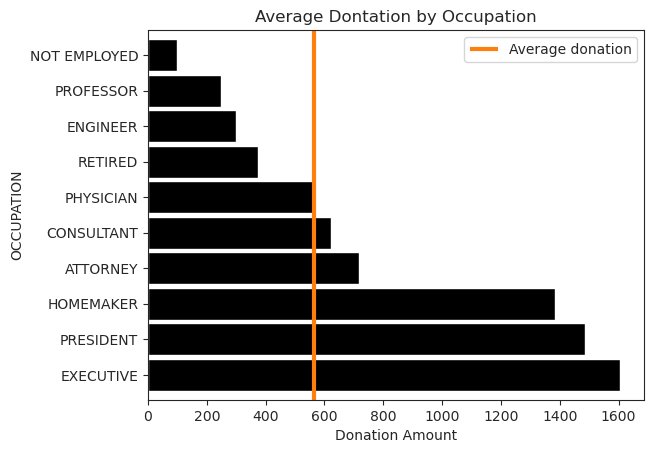

In [ ]:
ax = occupation_avg_dd.sort_values(ascending=False).plot.barh(color="k", width=0.9)
lim = ax.get_ylim()
ax.vlines(total_avg_dd, *lim, color="C1", linewidth=3)
ax.legend(["Average donation"])
ax.set(xlabel="Donation Amount", title="Average Dontation by Occupation")


[Text(0.5, 0, 'Donation Amount'),
 Text(0.5, 1.0, 'Average Dontation by Occupation')]

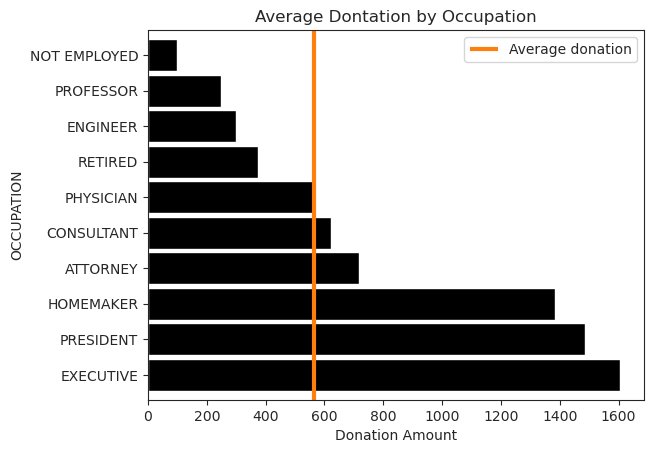

In [ ]:
ax = (
    occupation_avg_pl.to_pandas()
    .set_index("OCCUPATION")
    .squeeze()
    .sort_values(ascending=False)
    .plot.barh(color="k", width=0.9)
)
lim = ax.get_ylim()
ax.vlines(total_avg_pl, *lim, color="C1", linewidth=3)
ax.legend(["Average donation"])
ax.set(xlabel="Donation Amount", title="Average Dontation by Occupation")


In [71]:
daily_dd = (
    indiv_dd[["TRANSACTION_DT", "TRANSACTION_AMT"]]
    .dropna()
    .set_index("TRANSACTION_DT")["TRANSACTION_AMT"]
    .resample("D")
    .sum()
).compute()
daily_dd


TRANSACTION_DT
1916-01-23    1000
1916-01-24       0
              ... 
2201-06-01       0
2201-06-02    2000
Freq: D, Name: TRANSACTION_AMT, Length: 104226, dtype: int32

In [72]:
daily_pl = (
    indiv_pl.select(["TRANSACTION_DT", "TRANSACTION_AMT"])
    .drop_nulls()
    .sort("TRANSACTION_DT")
    .groupby_dynamic("TRANSACTION_DT", every="1d")
    .agg(pl.col("TRANSACTION_AMT").sum())
    .collect()
)
daily_pl


TRANSACTION_DT,TRANSACTION_AMT
date,i32
1015-10-05,2700
1015-10-19,200
1015-10-30,1000
1216-07-03,25
1916-01-23,1000
1931-04-23,1000
2000-01-13,2400
2000-01-31,150
2000-02-28,1000


[(0.0, 83407.5242),
 Text(0.5, 1.0, 'Daily Donations'),
 Text(0, 0.5, '$ (thousands)')]

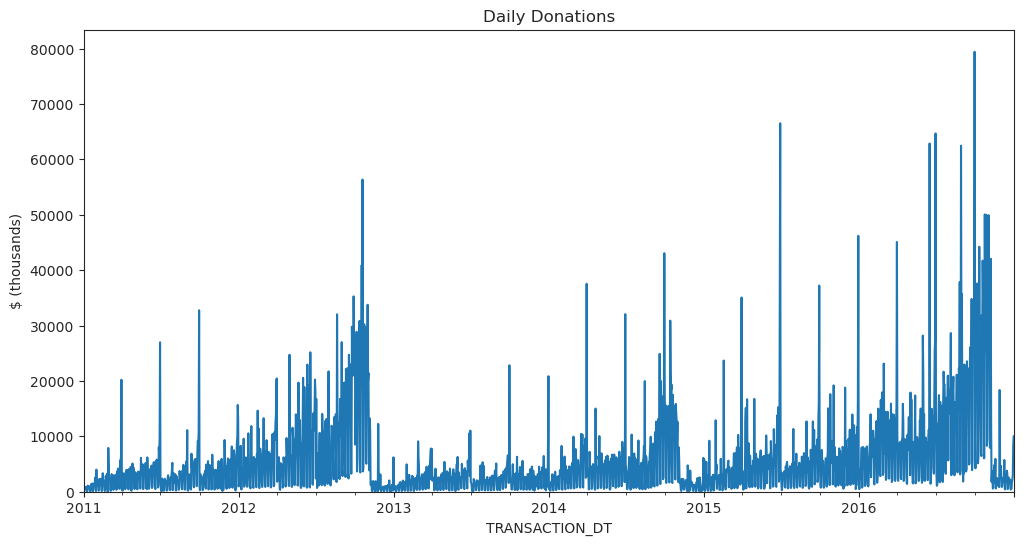

In [73]:
subset_dd = daily_dd.loc["2011":"2016"]
ax = subset_dd.div(1000).plot(figsize=(12, 6))
ax.set(ylim=0, title="Daily Donations", ylabel="$ (thousands)")


[(0.0, 83407.5242),
 Text(0.5, 1.0, 'Daily Donations'),
 Text(0, 0.5, '$ (thousands)')]

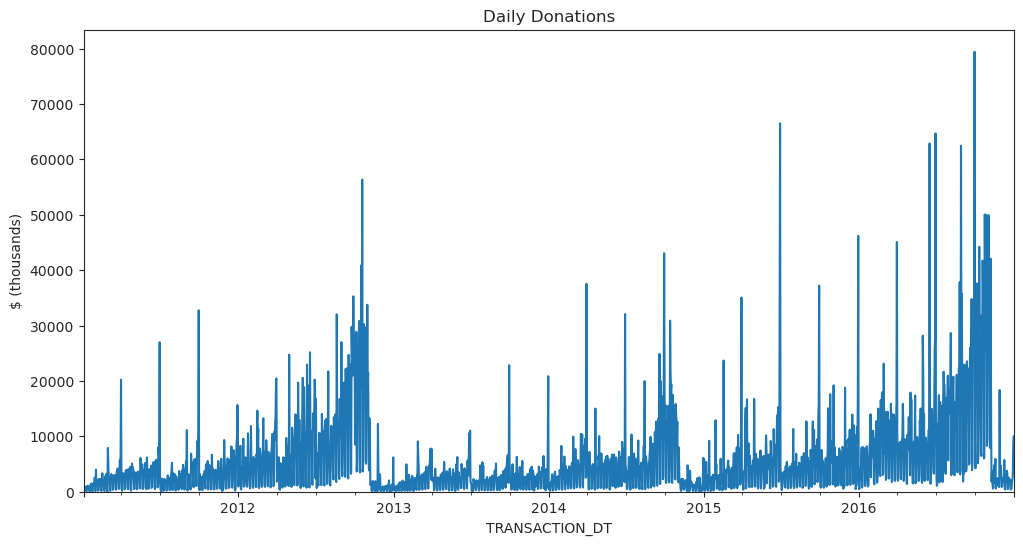

In [74]:
subset_pl = daily_pl.filter(
    pl.col("TRANSACTION_DT").is_between(date(2011, 1, 1), date(2017, 1, 1))
)
ax = (
    subset_pl.select(
        [pl.col("TRANSACTION_DT").cast(pl.Datetime), pl.col("TRANSACTION_AMT") / 1000]
    )
    .to_pandas()
    .set_index("TRANSACTION_DT")
    .squeeze()
    .plot(figsize=(12, 6))
)
ax.set(ylim=0, title="Daily Donations", ylabel="$ (thousands)")


In [75]:
cm_dd = (
    # This data is small but we use dask here as a convenient way to read a glob of files.
    dd.read_parquet(fec_dir / "cm*.pq")
    .compute()
    # Some committees change their name, but the ID stays the same
    # If we use .last instead of .nth(-1), we get the last non-null value
    .groupby("CMTE_ID", as_index=False)
    .nth(-1)
)
cm_dd


,CMTE_ID,CMTE_NM,CMTE_PTY_AFFILIATION
7,C00000794,LENT & SCRIVNER PAC,UNK
15,C00001156,MICHIGAN LEAGUE OF COMMUNITY BANKS POLITICAL A...,NaN
...,...,...,...
17649,C99002396,AMERICAN POLITICAL ACTION COMMITTEE,NaN
17650,C99003428,THIRD DISTRICT REPUBLICAN PARTY,REP


In [76]:
pl.toggle_string_cache(True)
cm_pl = (
    # This data is small so we don't use streaming.
    pl.read_parquet(fec_dir / "cm*.pq")
    # Some committees change their name, but the ID stays the same
    .groupby("CMTE_ID", maintain_order=True).last()
)
cm_pl


CMTE_ID,CMTE_NM,CMTE_PTY_AFFILIATION
str,str,cat
"""C00000042""","""ILLINOIS TOOL ...",null
"""C00000059""","""HALLMARK CARDS...","""UNK"""
"""C00000422""","""AMERICAN MEDIC...",null
"""C00000489""","""D R I V E POLI...",null
"""C00000547""","""KANSAS MEDICAL...","""UNK"""
"""C00000638""","""INDIANA STATE ...",null
"""C00000729""","""AMERICAN DENTA...","""UNK"""
"""C00000794""","""LENT & SCRIVN...","""UNK"""
"""C00000885""","""INTERNATIONAL ...","""UNK"""


In [84]:
indiv_filtered_dd = indiv_dd[
    (indiv_dd["TRANSACTION_DT"] >= pd.Timestamp("2007-01-01"))
    & (indiv_dd["TRANSACTION_DT"] <= pd.Timestamp("2017-01-01"))
]

merged_dd = dd.merge(indiv_filtered_dd, cm_dd, on="CMTE_ID")


In [83]:
indiv_filtered_pl = indiv_pl.filter(
    pl.col("TRANSACTION_DT").is_between(
        date(2007, 1, 1), date(2017, 1, 1), include_bounds=True
    )
)

merged_pl = indiv_filtered_pl.join(cm_pl.lazy(), on="CMTE_ID")


In [79]:
party_donations_dd = (
    (
        merged_dd.groupby(["TRANSACTION_DT", "CMTE_PTY_AFFILIATION"])[
            "TRANSACTION_AMT"
        ].sum()
    )
    .compute()
    .sort_index()
)


In [80]:
party_donations_pl = (
    merged_pl.groupby(["TRANSACTION_DT", "CMTE_PTY_AFFILIATION"])
    .agg(pl.col("TRANSACTION_AMT").sum())
    .sort(["TRANSACTION_DT", "CMTE_PTY_AFFILIATION"])
    .collect()
)


PARTITIONED DS


[Text(0.5, 1.0, 'Daily Donations (30-D Moving Average)'), Text(0.5, 0, 'Date')]

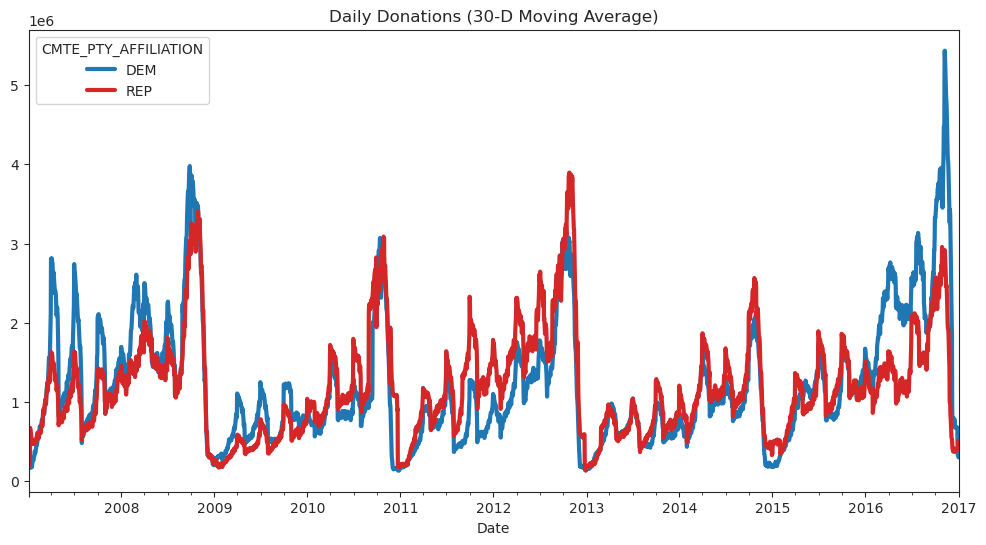

In [81]:
ax = (
    party_donations_dd.loc[:, ["REP", "DEM"]]
    .unstack("CMTE_PTY_AFFILIATION")
    .iloc[1:]
    .rolling("30D")
    .mean()[["DEM", "REP"]]
    .plot(color=["C0", "C3"], figsize=(12, 6), linewidth=3)
)
ax.set(title="Daily Donations (30-D Moving Average)", xlabel="Date")


[Text(0.5, 1.0, 'Daily Donations (30-D Moving Average)'), Text(0.5, 0, 'Date')]

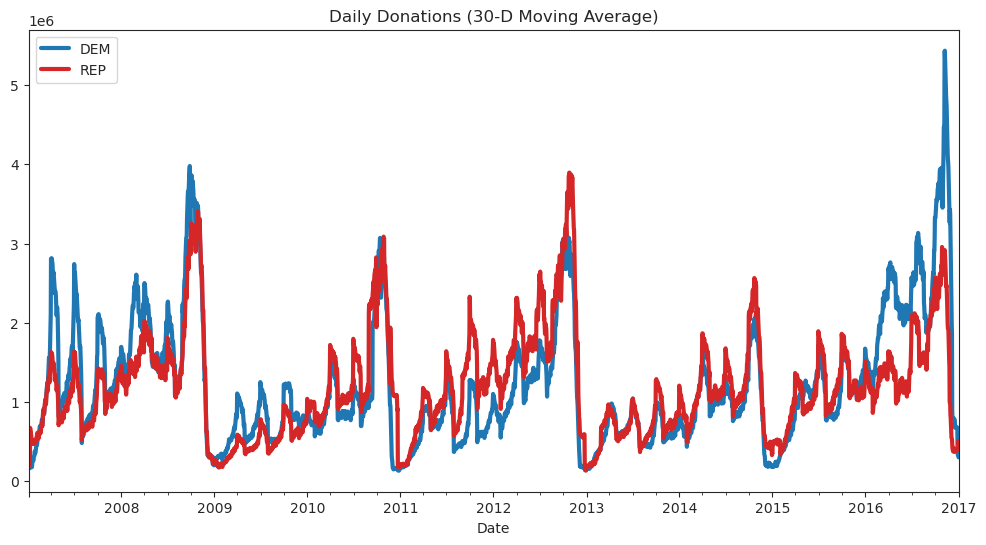

In [82]:
ax = (
    party_donations_pl.filter(pl.col("CMTE_PTY_AFFILIATION").is_in(["DEM", "REP"]))
    .pivot(
        index="TRANSACTION_DT", columns="CMTE_PTY_AFFILIATION", values="TRANSACTION_AMT"
    )[1:, :]
    .select(
        [pl.col("TRANSACTION_DT"), pl.col(pl.Int32).rolling_mean(30, min_periods=0)]
    )
    .to_pandas()
    .set_index("TRANSACTION_DT")[["DEM", "REP"]]
    .plot(color=["C0", "C3"], figsize=(12, 6), linewidth=3)
)
ax.set(title="Daily Donations (30-D Moving Average)", xlabel="Date")


In [60]:
!cp data/fec/indiv10.pq tmp/

In [67]:
import polars as pl
import dask.dataframe as dd
occ_dd = dd.read_parquet(
    "tmp/indiv*.pq", engine="pyarrow", columns=["OCCUPATION"]
)
n_rows = 5
most_common_dd = occ_dd["OCCUPATION"].head(n_rows).value_counts()
most_common_dd.head()

PUBLIC RELATIONS CONSULTANT           3
LOW INCOME HOUSING DEVELOPMENT        0
VETERAN SERVICE OFFICER               0
PROPERTY EXCHANGE                     0
CHIEF TECHLOGY OFFICER AND FOUNDER    0
Name: OCCUPATION, dtype: int64

In [68]:
with pl.StringCache():  # otherwise we can't read categoricals from multiple files
    occ_pl = pl.scan_parquet("tmp/indiv*.pq", cache=False)
    counts = (
        occ_pl
        .select(pl.col("OCCUPATION").head(n_rows).value_counts(multithreaded=True, sort=True))
        .collect()
    )
counts.head()

OCCUPATION
struct[2]
"{""RETIRED"",3}"
"{null,2}"


Reading the first few rows of a directory containing indiv08.pq and indiv10.pq is enough to cause
mislabelled value counts, even though these rows are just rows of indiv08.pq, and reading that by itself is fine. 


In [69]:
!mkdir tmp2

In [88]:
for year in ("08", "10"):
    (
        pl.scan_parquet(f"tmp/indiv{year}.pq", cache=False)
        .select(pl.col("OCCUPATION").head(2))
        .collect()
        .write_parquet(f"tmp2/indiv{year}.pq")
    )
with pl.StringCache():  # otherwise we can't read categoricals from multiple files
    occ_pl = pl.scan_parquet("tmp2/indiv*.pq", cache=False)
    counts = (
        occ_pl
        .select(pl.col("OCCUPATION").value_counts(multithreaded=True, sort=True))
        .collect()
    )
counts.head()

OCCUPATION
struct[2]
"{""RETIRED"",2}"
"{""NORTHROP GRUMMAN"",1}"
"{""MAINE MEDICAL CENTER"",1}"


In [89]:
with pl.StringCache():
    print(pl.scan_parquet("tmp2/indiv*.pq", cache=False).head(6).collect())

shape: (4, 1)
┌─────────────────────────────┐
│ OCCUPATION                  │
│ ---                         │
│ cat                         │
╞═════════════════════════════╡
│ PUBLIC RELATIONS CONSULTANT │
│ PUBLIC RELATIONS CONSULTANT │
│ RETIRED                     │
│ ATTORNEY, RETIRED           │
└─────────────────────────────┘


In [103]:
with pl.StringCache():
    print(pl.scan_parquet("tmp2/indiv*.pq", cache=False).collect())

shape: (4, 1)
┌─────────────────────────────┐
│ OCCUPATION                  │
│ ---                         │
│ cat                         │
╞═════════════════════════════╡
│ PUBLIC RELATIONS CONSULTANT │
│ PUBLIC RELATIONS CONSULTANT │
│ RETIRED                     │
│ ATTORNEY, RETIRED           │
└─────────────────────────────┘


In [95]:
!mkdir tmp3

In [105]:
df1 = pl.DataFrame([pl.Series("OCCUPATION", ["PUBLIC RELATIONS CONSULTANT", "PUBLIC RELATIONS CONSULTANT"], pl.Categorical)])
df2 = pl.DataFrame([pl.Series("OCCUPATION", ["RETIRED", "ATTORNEY, RETIRED"], pl.Categorical)])
df1.write_parquet("tmp3/df1.pq")
df2.write_parquet("tmp3/df2.pq")
with pl.StringCache():
    print(pl.scan_parquet("tmp3/*.pq", cache=False).collect())
    print(
        pl.scan_parquet("tmp3/*.pq", cache=False)
        .select(pl.col("OCCUPATION")
        .value_counts(multithreaded=True, sort=True))
        .collect()
    )

shape: (4, 1)
┌─────────────────────────────┐
│ OCCUPATION                  │
│ ---                         │
│ cat                         │
╞═════════════════════════════╡
│ PUBLIC RELATIONS CONSULTANT │
│ PUBLIC RELATIONS CONSULTANT │
│ RETIRED                     │
│ ATTORNEY, RETIRED           │
└─────────────────────────────┘
shape: (3, 1)
┌─────────────────────────────────────┐
│ OCCUPATION                          │
│ ---                                 │
│ struct[2]                           │
╞═════════════════════════════════════╡
│ {"PUBLIC RELATIONS CONSULTANT",2... │
│ {"RETIRED",1}                       │
│ {"ATTORNEY, RETIRED",1}             │
└─────────────────────────────────────┘


In [110]:
import pyarrow.parquet as pq
pq.read_schema("tmp2/indiv08.pq")

OCCUPATION: dictionary<values=string, indices=int32, ordered=0>

In [109]:
pq.read_schema("tmp3/df1.pq")

OCCUPATION: dictionary<values=string, indices=int32, ordered=0>